<a href="https://colab.research.google.com/github/vitesempl/RK-IDE-Julia/blob/master/Julia%20Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing **Julia** on **Google Colab**


Steps how to run **Julia**:
1.   Run the block below and install Julia Kernel
2.   Аfter installation (message `DONE`) go to notebook settings
3.   Select `Julia 1.6.2` again as runtime



In [1]:
!curl -sSL "https://julialang-s3.julialang.org/bin/linux/x64/1.6/julia-1.6.2-linux-x86_64.tar.gz" -o julia.tar.gz
!tar -xzf julia.tar.gz -C /usr --strip-components 1
!rm -rf julia.tar.gz*
!julia -e 'using Pkg; pkg"add IJulia; add Plots; precompile"' &> /dev/null
!echo "DONE"

DONE


# **Julia Code**

In [1]:
using InteractiveUtils;
versioninfo()

Julia Version 1.6.2
Commit 1b93d53fc4 (2021-07-14 15:36 UTC)
Platform Info:
  OS: Linux (x86_64-pc-linux-gnu)
  CPU: Intel(R) Xeon(R) CPU @ 2.20GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-11.0.1 (ORCJIT, broadwell)


## Importing a **Julia** package from **GitHub**

In [2]:
using Pkg
Pkg.add(url="https://github.com/vitesempl/RK-IDE-Julia")
# Pkg.activate("./")  # if you work in repository with package
using RK

     Cloning git-repo `https://github.com/vitesempl/RK-IDE-Julia`
    Updating git-repo `https://github.com/vitesempl/RK-IDE-Julia`
    Updating registry at `~/.julia/registries/General`
   Resolving package versions...
    Updating `~/.julia/environments/v1.6/Project.toml`
  [7b8691fb] + RK v0.1.0 `https://github.com/vitesempl/RK-IDE-Julia#master`
    Updating `~/.julia/environments/v1.6/Manifest.toml`
  [7b8691fb] + RK v0.1.0 `https://github.com/vitesempl/RK-IDE-Julia#master`
Precompiling project...
  ✓ RK
  1 dependency successfully precompiled in 3 seconds (123 already precompiled)


## **Main Code**

In [3]:
using Plots

### Definition of functions for output 

In [4]:
function OutputSolution()
    # Output numerical solution in the end
    nz = length(history(tspan[1]))
    if nz == 1
        println("y(", tspan[2], ") = ", sol[2][end])
    else
        for i = 1 : nz
            println("y", i, "(", tspan[2], ") = ", (sol[2]')[end - nz + i])
        end
    end
end

OutputSolution (generic function with 1 method)

In [5]:
function OutputConvOrder(; dde=false, overlapping=false)
    # Check convergence order of examples
    # "dde=true" - if equation is DDE (with dicrete delays)
    n_start = 2
    n_end = 8
    err = zeros(n_end - n_start + 1)
    nsteps = zeros(n_end - n_start + 1)

    i = 1
    for steppow = 2 : n_end
        stepsize = (2.0)^(-steppow)
        
        if dde
            if overlapping
                sol = ide_solve(idefun, K, delays_int, history, tspan, stepsize, delays, overlapping=true)
            else
                sol = ide_solve(idefun, K, delays_int, history, tspan, stepsize, delays)
            end
        else
            sol = ide_solve(idefun, K, delays_int, history, tspan, stepsize)
        end
        
        err[i] = abs(analytic_sol - sol[2][end])
        nsteps[i] = stepsize

        i += 1
    end

    println()
    println("Convergence order: ", (log10(err[end-1]) - log10(err[end])) / (log10((2.0)^(-n_end+1)) - log10((2.0)^(-n_end))))

    X_ticks = [(10.0)^(-x) for x in 1:15]
    Y_ticks = [(10.0)^(-x) for x in 0:0.5:3]
    display(plot(err, 
                nsteps, 
                linewidth=3, 
                xaxis=:log10, 
                yaxis=:log10, 
                xticks=X_ticks, 
                yticks=Y_ticks, 
                xlabel="ERROR", 
                ylabel="STEPSIZE",
                legend=false, 
                title="Convergence order"))
end

OutputConvOrder (generic function with 1 method)

### Example 1 (only integral)

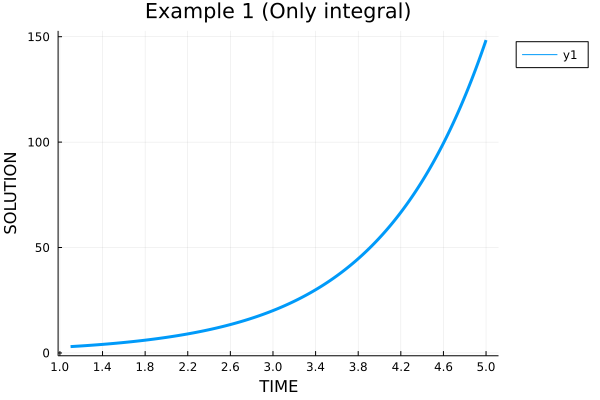

y(5.0) = 148.41315916549067



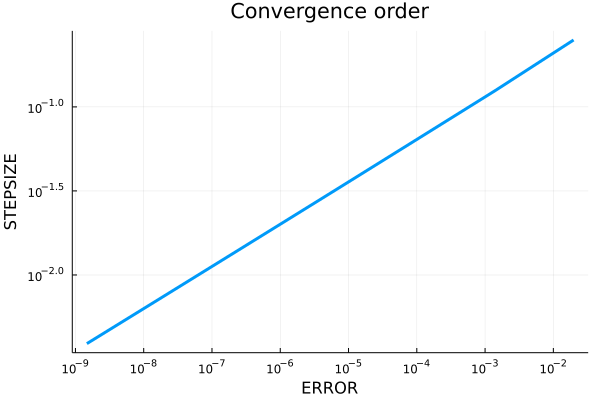

Convergence order: 3.99502542826273


In [6]:
idefun(t,y,z,i) = ((t - 1) * exp(t^2) * i) / (exp(-1) * y[1] - 1)
K(t,s,y)        = y * exp(-s * t)
delays_int(t)   = t - 1  # lower integration limit
history(t)      = exp(t)

tspan = [1.1 5]
stepsize = 1e-2

sol = ide_solve(idefun, K, delays_int, history, tspan, stepsize)

# Output vector of times t     #print(sol[1])
# Output vector of solutions y #print(sol[2])
OutputSolution()

display(plot(sol, 
            linewidth=3, 
            xlabel="TIME", 
            ylabel="SOLUTION", 
            xticks=trunc(Int,tspan[1]):(tspan[2]-trunc(Int,tspan[1]))/10:tspan[2], 
            title="Example 1 (Only integral)", 
            legend=:outertopright))

# Check convergence order
fun(t) = exp(t)
analytic_sol = fun(tspan[end]);

# dde=true - if equation is DDE (with dicrete delays 'z')
# overlapping=true - if equation has overlapping in discrete delays
OutputConvOrder() 

### Example 2 (integral+discrete delays)

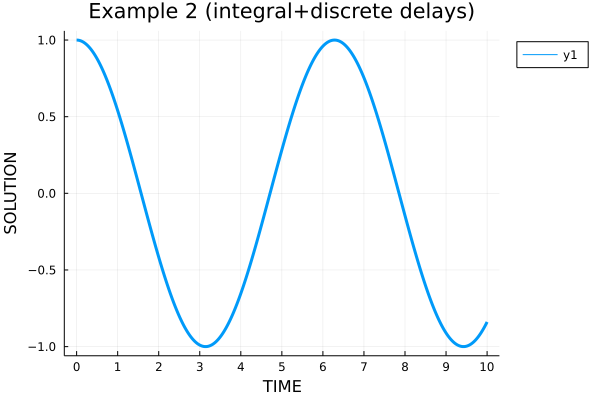

y(10) = -0.8390715203132826



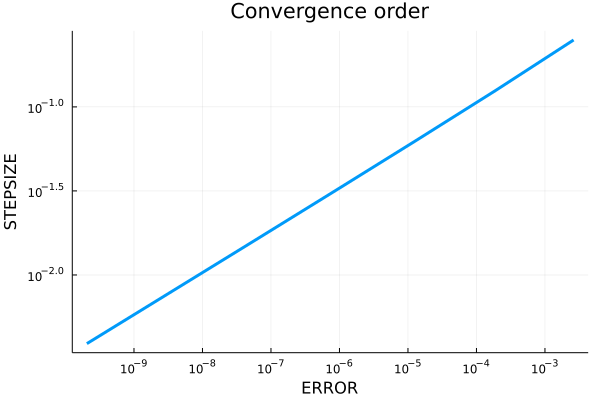

Convergence order: 3.9943743358024104


In [7]:
idefun(t,y,z,i) = (1 + exp(-pi / 2)) * y - exp(-pi / 2) * z - 2 * exp(-2 * t) * i
K(t,s,y)        = y * exp(t + s)
delays(t,y)     = t - pi / 2
delays_int(t)   = t - pi / 2
history(t)      = cos(t)

tspan = [0 10]
stepsize = 1e-2

sol = ide_solve(idefun, K, delays_int, history, tspan, stepsize, delays)

OutputSolution()

display(plot(sol, 
            linewidth=3, 
            xlabel="TIME", 
            ylabel="SOLUTION", 
            xticks=trunc(Int,tspan[1]):(tspan[2]-trunc(Int,tspan[1]))/10:tspan[2], 
            title="Example 2 (integral+discrete delays)", 
            legend=:outertopright))

# Check convergence order
fun(t) = cos(t)
analytic_sol = fun(tspan[end]);

# dde=true - if equation is DDE (with dicrete delays 'z')
# overlapping=true - if equation has overlapping in discrete delays
OutputConvOrder(dde=true) 

### Example 3 (integral+discrete delays+overlapping)

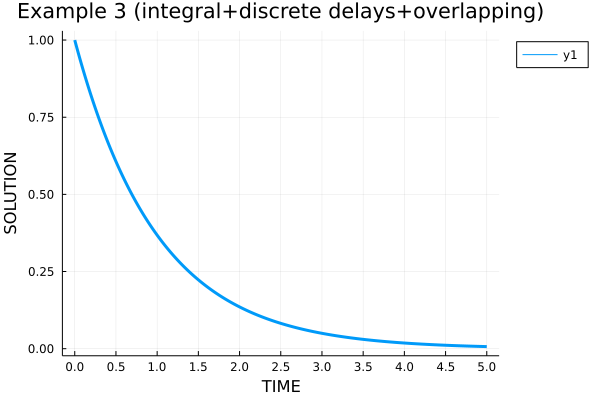

y(5) = 0.006737946980531031



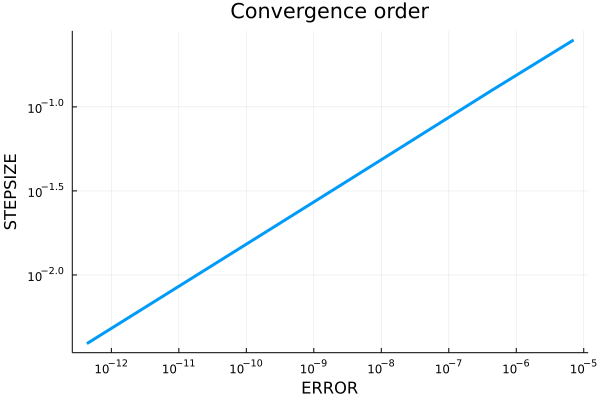

Convergence order: 3.9959662854006837


In [8]:
idefun(t,y,z,i) = -y.^2 - t * exp(t^2) * z^4 * i
K(t,s,y)        = y * exp(s - s * t)
delays(t,y)     = t / 2
delays_int(t)   = t - 1
history(t)      = exp(-t)

tspan = [0 5]
stepsize = 1e-2

sol = ide_solve(idefun, K, delays_int, history, tspan, stepsize, delays, overlapping=true)

OutputSolution()

display(plot(sol, 
            linewidth=3, 
            xlabel="TIME", 
            ylabel="SOLUTION", 
            xticks=trunc(Int,tspan[1]):(tspan[2]-trunc(Int,tspan[1]))/10:tspan[2], 
            title="Example 3 (integral+discrete delays+overlapping)", 
            legend=:outertopright))

# Check convergence order
fun(t) = exp(-t)
analytic_sol = fun(tspan[end]);

# dde=true - if equation is DDE (with dicrete delays 'z')
# overlapping=true - if equation has overlapping in discrete delays
OutputConvOrder(dde=true, overlapping=true) 

### Example 4 (2 integrals)

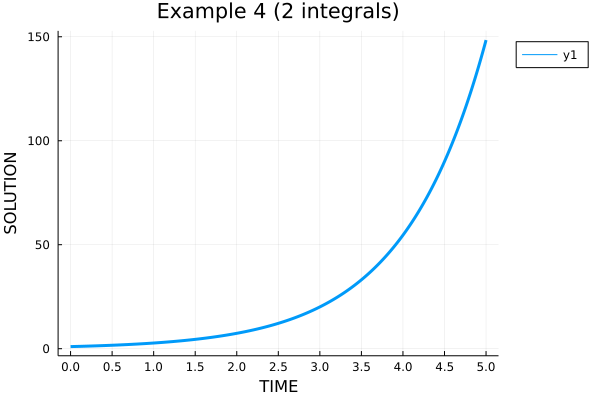

y(5) = 148.4131591545674



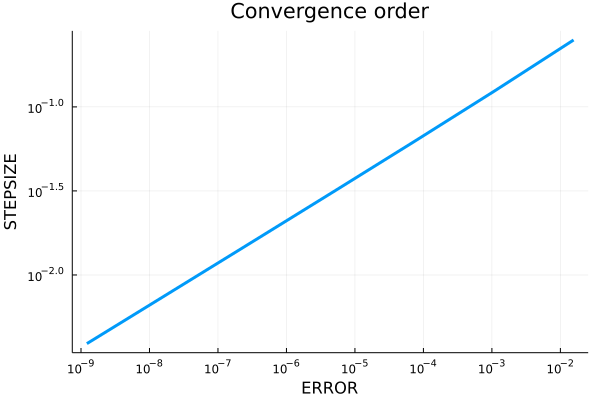

Convergence order: 3.993694784643424


In [9]:
idefun(t,y,z,i) = exp(1) - exp(t^2) / (z[1]^2) * (i[1] - exp(-2 * t) * i[2]) * (t - 1)
K(t,s,y)        = [ y * exp(-s * t);
                    y * exp(t * (2 - s))]
delays(t,y)     = t - 1
delays_int(t)   = [ t - 1;
                    t - 2 ]
history(t)      = exp(t)

tspan = [0 5]
stepsize = 1e-2

sol = ide_solve(idefun, K, delays_int, history, tspan, stepsize, delays)

OutputSolution()

display(plot(sol, 
            linewidth=3, 
            xlabel="TIME", 
            ylabel="SOLUTION", 
            xticks=trunc(Int,tspan[1]):(tspan[2]-trunc(Int,tspan[1]))/10:tspan[2], 
            title="Example 4 (2 integrals)", 
            legend=:outertopright))

# Check convergence order
fun(t) = exp(t)
analytic_sol = fun(tspan[end]);

# dde=true - if equation is DDE (with dicrete delays 'z')
# overlapping=true - if equation has overlapping in discrete delays
OutputConvOrder(dde=true) 

### Example 5 (2 discrete delays + *State-dependent*)

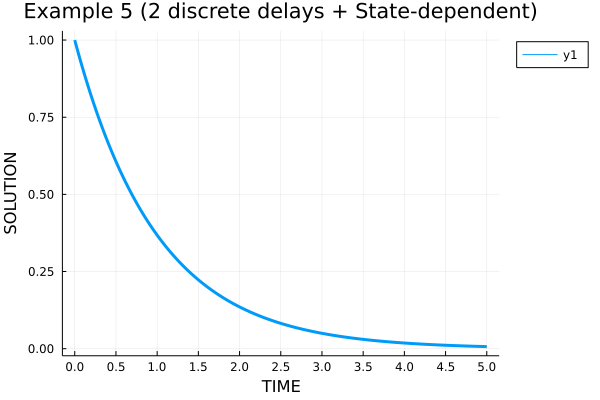

y(5) = 0.00673794702943691



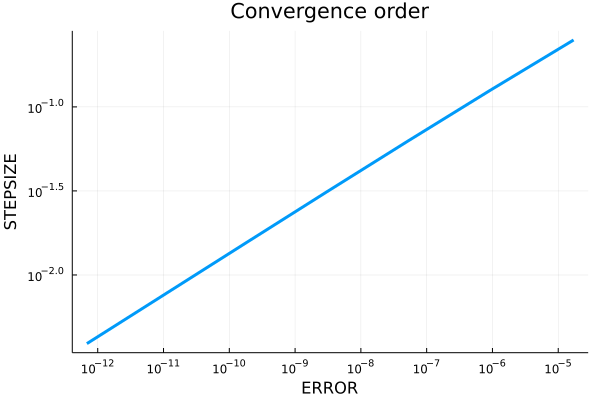

Convergence order: 4.035008963033188


In [10]:
idefun(t,y,z,i) = -z[1]^((t + 1) / 2) * z[2] * y.^2 * (1 + exp(t^2) * t * i[1]) / exp(0.5)
K(t,s,y)        = y * exp(s - s * t)
delays(t,y)     = [ (log(y[1]))^2 / (t + 1) - 0.5;
                    (t - 1) / 4 ]
delays_int(t)   = t / 2 - 1
history(t)      = exp(-t)

tspan = [0 5]
stepsize = 1e-2

sol = ide_solve(idefun, K, delays_int, history, tspan, stepsize, delays, overlapping=true)

OutputSolution()

display(plot(sol, 
            linewidth=3, 
            xlabel="TIME", 
            ylabel="SOLUTION", 
            xticks=trunc(Int,tspan[1]):(tspan[2]-trunc(Int,tspan[1]))/10:tspan[2], 
            title="Example 5 (2 discrete delays + State-dependent)", 
            legend=:outertopright))

# Check convergence order
fun(t) = exp(-t)
analytic_sol = fun(tspan[end]);

# dde=true - if equation is DDE (with dicrete delays 'z')
# overlapping=true - if equation has overlapping in discrete delays
OutputConvOrder(dde=true, overlapping=true) 

### Example 6 (system of equations)



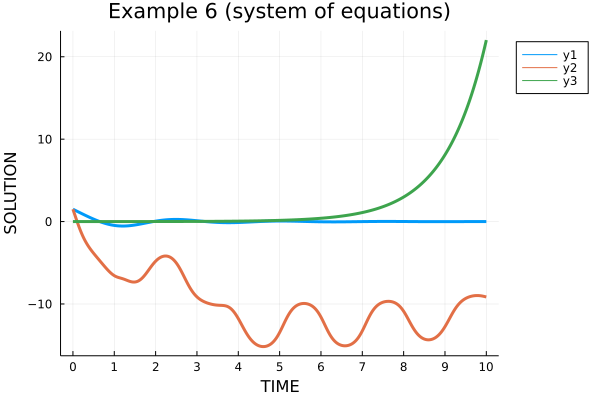

y1(10) = 0.004329876714667186
y2(10) = -9.145294283568145
y3(10) = 22.026465794883663


In [11]:
idefun(t,y,z,i) = [ -2.5 * i[1];
                    -15 * i[2];
                    0.001 * exp(t)]
K(t,s,y)        = [ sin(y[1]);
                    sin(y[2])]
delays_int(t)   = [ t - 1;
                    t - 1 ]
history(t)      = [ 1.5;
                    1.5;
                    0.001 * exp(t)]

tspan = [0 10]
stepsize = 1e-2

sol = ide_solve(idefun, K, delays_int, history, tspan, stepsize)

OutputSolution()

display(plot(sol, 
            linewidth=3, 
            xlabel="TIME", 
            ylabel="SOLUTION", 
            xticks=trunc(Int,tspan[1]):(tspan[2]-trunc(Int,tspan[1]))/10:tspan[2], 
            title="Example 6 (system of equations)", 
            legend=:outertopright))

### Examples (Yukihiko)

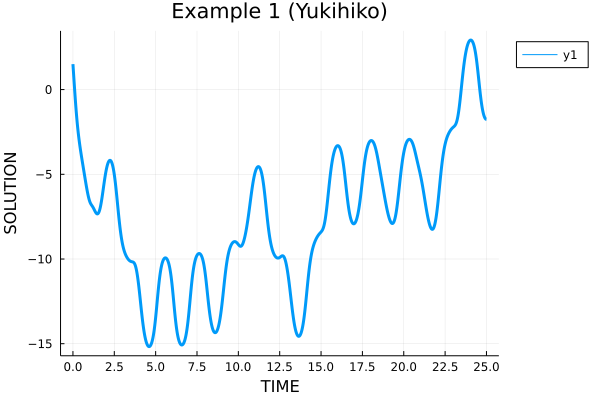

y(25) = -1.7601259984088782


In [12]:
idefun(t,y,z,i) = -15 * i
K(t,s,y)        = sin(y)
delays_int(t)   = t - 1
history(t)      = 1.5

tspan = [0 25]
stepsize = 1e-2

sol = ide_solve(idefun, K, delays_int, history, tspan, stepsize)

OutputSolution()

display(plot(sol, 
            linewidth=3, 
            xlabel="TIME", 
            ylabel="SOLUTION", 
            xticks=trunc(Int,tspan[1]):(tspan[2]-trunc(Int,tspan[1]))/10:tspan[2], 
            title="Example 1 (Yukihiko)", 
            legend=:outertopright))

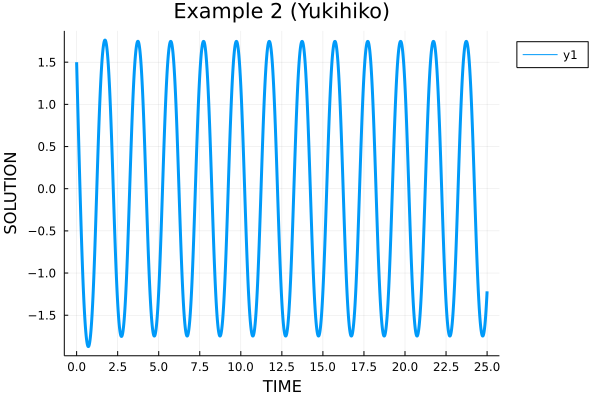

y(25) = -1.2167450853078887


In [13]:
idefun(t,y,z,i) = -7.5 * i

sol = ide_solve(idefun, K, delays_int, history, tspan, stepsize)

OutputSolution()

display(plot(sol, 
            linewidth=3, 
            xlabel="TIME", 
            ylabel="SOLUTION", 
            xticks=trunc(Int,tspan[1]):(tspan[2]-trunc(Int,tspan[1]))/10:tspan[2], 
            title="Example 2 (Yukihiko)", 
            legend=:outertopright))

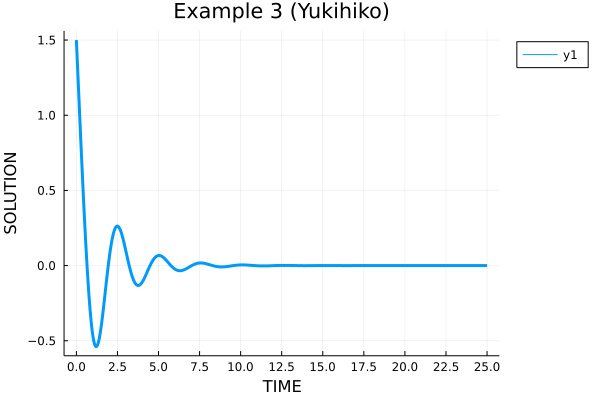

y(25) = 8.176590465143174e-7


In [14]:
idefun(t,y,z,i) = -2.5 * i

sol = ide_solve(idefun, K, delays_int, history, tspan, stepsize)

OutputSolution()

display(plot(sol, 
            linewidth=3, 
            xlabel="TIME", 
            ylabel="SOLUTION", 
            xticks=trunc(Int,tspan[1]):(tspan[2]-trunc(Int,tspan[1]))/10:tspan[2], 
            title="Example 3 (Yukihiko)", 
            legend=:outertopright))

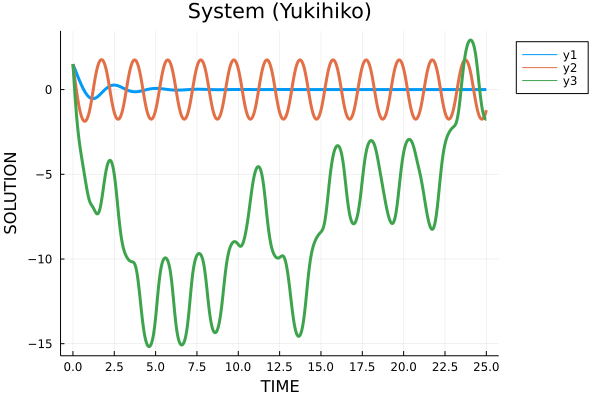

y1(25) = 8.176590465143175e-7
y2(25) = -1.2167450853078874
y3(25) = -1.76012599833389


In [15]:
idefun(t,y,z,i) = [ -2.5*i[1];
                    -7.5*i[2];
                    -15*i[3] ]
K(t,s,y)        = [ sin(y[1]);
                    sin(y[2]);
                    sin(y[3]) ]
delays_int(t)   = [ t-1;
                    t-1;
                    t-1 ]
history(t)      = [ 1.5;
                    1.5;
                    1.5 ]

tspan = [0 25]
stepsize = 1e-2

sol = ide_solve(idefun, K, delays_int, history, tspan, stepsize)

OutputSolution()

display(plot(sol, 
            linewidth=3, 
            xlabel="TIME", 
            ylabel="SOLUTION", 
            xticks=trunc(Int,tspan[1]):(tspan[2]-trunc(Int,tspan[1]))/10:tspan[2], 
            title="System (Yukihiko)", 
            legend=:outertopright))

## Speed test (5 examples) RK4 method



In [16]:
stepsize = 1e-2;

In [17]:
idefun(t,y,z,i) = ((t - 1) * exp(t^2) * i) / (exp(-1) * y[1] - 1)
K(t,s,y)        = y * exp(-s * t)
delays_int(t)   = t - 1
history(t)      = exp(t)

tspan = [1.1 5]

print("Elapsed time:")
@time sol = ide_solve(idefun, K, delays_int, history, tspan, stepsize)

OutputSolution()

Elapsed time:  1.049196 seconds (2.64 M allocations: 127.196 MiB, 4.06% gc time, 84.35% compilation time)
y(5.0) = 148.41315916549067


In [18]:
idefun(t,y,z,i) = -y.^2 - t * exp(t^2) * z^4 * i
K(t,s,y)        = y * exp(s - s * t)
delays(t,y)     = t / 2
delays_int(t)   = t - 1
history(t)      = exp(-t)



print("Elapsed time:")
@time sol = ide_solve(idefun, K, delays_int, history, tspan, stepsize, delays)

OutputSolution()

Elapsed time:  1.574025 seconds (3.62 M allocations: 188.982 MiB, 4.42% gc time, 89.30% compilation time)
y(5.0) = 0.006737946975676252


In [19]:
idefun(t,y,z,i) = exp(1) - exp(t^2) / (z[1]^2) * (i[1] - exp(-2 * t) * i[2]) * (t - 1)
K(t,s,y)        = [ y * exp(-s * t);
                    y * exp(t * (2 - s))]
delays(t,y)     = t - 1
delays_int(t)   = [ t - 1;
                    t - 2 ]
history(t)      = exp(t)

tspan = [0 5]

print("Elapsed time:")
@time sol = ide_solve(idefun, K, delays_int, history, tspan, stepsize, delays)

OutputSolution()

Elapsed time:  2.254177 seconds (10.31 M allocations: 461.098 MiB, 5.68% gc time, 66.94% compilation time)
y(5) = 148.4131591545674


In [20]:
idefun(t,y,z,i) = -z[1]^((t + 1) / 2) * z[2] * y.^2 * (1 + exp(t^2) * t * i[1]) / exp(0.5)
K(t,s,y)        = y * exp(s - s * t)
delays(t,y)     = [ (log(y[1]))^2 / (t + 1) - 0.5;
                    (t - 1) / 4 ]
delays_int(t)   = t / 2 - 1
history(t)      = exp(-t)

tspan = [0 5]

print("Elapsed time:")
@time sol = ide_solve(idefun, K, delays_int, history, tspan, stepsize, delays)

OutputSolution()

Elapsed time:  1.786916 seconds (7.14 M allocations: 306.149 MiB, 4.06% gc time, 69.32% compilation time)
y(5) = 0.006737947554922938


In [21]:
idefun(t,y,z,i) = [ -2.5 * i[1];
                    -15 * i[2];
                    0.001 * exp(t)]
K(t,s,y)        = [ sin(y[1]);
                    sin(y[2])]
delays_int(t)   = [ t - 1;
                    t - 1 ]
history(t)      = [ 1.5;
                    1.5;
                    0.001 * exp(t)]

tspan = [0 10]

print("Elapsed time:")
@time sol = ide_solve(idefun, K, delays_int, history, tspan, stepsize)

OutputSolution()

Elapsed time:  2.647508 seconds (14.07 M allocations: 720.301 MiB, 7.25% gc time, 47.15% compilation time)
y1(10) = 0.004329876714667186
y2(10) = -9.145294283568145
y3(10) = 22.026465794883663


## Speed test (5 examples) Tavernini method

In [22]:
stepsize = 1e-2;

In [23]:
idefun(t,y,z,i) = ((t - 1) * exp(t^2) * i) / (exp(-1) * y[1] - 1)
K(t,s,y)        = y * exp(-s * t)
delays_int(t)   = t - 1
history(t)      = exp(t)

tspan = [1.1 5]

print("Elapsed time:")
@time sol = ide_solve(idefun, K, delays_int, history, tspan, stepsize, overlapping=true)

OutputSolution()

Elapsed time:  1.070464 seconds (2.67 M allocations: 132.202 MiB, 4.58% gc time, 82.28% compilation time)
y(5.0) = 148.41315926226974


In [24]:
idefun(t,y,z,i) = -y.^2 - t * exp(t^2) * z^4 * i
K(t,s,y)        = y * exp(s - s * t)
delays(t,y)     = t / 2
delays_int(t)   = t - 1
history(t)      = exp(-t)



print("Elapsed time:")
@time sol = ide_solve(idefun, K, delays_int, history, tspan, stepsize, overlapping=true)

OutputSolution()

Elapsed time:  1.058592 seconds (2.64 M allocations: 130.558 MiB, 5.47% gc time, 80.79% compilation time)
y(5.0) = 0.14484008590353548


In [25]:
idefun(t,y,z,i) = exp(1) - exp(t^2) / (z[1]^2) * (i[1] - exp(-2 * t) * i[2]) * (t - 1)
K(t,s,y)        = [ y * exp(-s * t);
                    y * exp(t * (2 - s))]
delays(t,y)     = t - 1
delays_int(t)   = [ t - 1;
                    t - 2 ]
history(t)      = exp(t)

tspan = [0 5]

print("Elapsed time:")
@time sol = ide_solve(idefun, K, delays_int, history, tspan, stepsize, delays, overlapping=true)

OutputSolution()

Elapsed time:  2.267237 seconds (10.40 M allocations: 474.255 MiB, 5.55% gc time, 66.07% compilation time)
y(5) = 148.41315915324557


In [26]:
idefun(t,y,z,i) = -z[1]^((t + 1) / 2) * z[2] * y.^2 * (1 + exp(t^2) * t * i[1]) / exp(0.5)
K(t,s,y)        = y * exp(s - s * t)
delays(t,y)     = [ (log(y[1]))^2 / (t + 1) - 0.5;
                    (t - 1) / 4 ]
delays_int(t)   = t / 2 - 1
history(t)      = exp(-t)

tspan = [0 5]

print("Elapsed time:")
@time sol = ide_solve(idefun, K, delays_int, history, tspan, stepsize, delays, overlapping=true)

OutputSolution()

Elapsed time:  1.835641 seconds (7.26 M allocations: 319.128 MiB, 4.92% gc time, 67.48% compilation time)
y(5) = 0.00673794702943691


In [27]:
idefun(t,y,z,i) = [ -2.5 * i[1];
                    -15 * i[2];
                    0.001 * exp(t)]
K(t,s,y)        = [ sin(y[1]);
                    sin(y[2])]
delays_int(t)   = [ t - 1;
                    t - 1 ]
history(t)      = [ 1.5;
                    1.5;
                    0.001 * exp(t)]

tspan = [0 10]

print("Elapsed time:")
@time sol = ide_solve(idefun, K, delays_int, history, tspan, stepsize, overlapping=true)

OutputSolution()

Elapsed time:  2.661360 seconds (14.16 M allocations: 772.103 MiB, 7.18% gc time, 46.54% compilation time)
y1(10) = 0.004329876774282104
y2(10) = -9.145230333664246
y3(10) = 22.026465794883663
